# 03: 次元削減 - 行列因子分解アプローチ

このノートブックでは、次元削減のもう一つの強力なアプローチである「行列因子分解（Matrix Factorization）」について学びます。このアプローチの根底にあるのは、元の高次元データ行列 $V$ を、より低い次元を持つ2つの行列 $W$ と $H$ の積で近似するという考え方です。

$$
V_{n \times m} \approx W_{n \times k} H_{k \times m} \quad (k \ll n, m)
$$

ここでは、特に代表的な2つの手法、**非負値行列因子分解 (NMF)** と **Uniform Manifold Approximation and Projection (UMAP)** を取り上げます。NMFはデータに「非負」という制約を課すことで、データを構成する「部分」を基底として学習します。一方、UMAPは最新のマニフォールド学習手法であり、位相的データ解析の理論に基づいて、大域的な構造と局所的な構造の両方を保持することを目指します。

**参考論文:**
*   (NMF) Lee, D. D., & Seung, H. S. (1999). Learning the parts of objects by non-negative matrix factorization. *Nature*, 401(6755), 788-791.
*   (UMAP) McInnes, L., Healy, J., & Melville, J. (2018). UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction. *arXiv preprint arXiv:1802.03426*.

**このノートブックで学ぶこと:**
1.  行列因子分解に基づく次元削減の基本概念。
2.  NMFの理論：非負制約がどのように「部分ベース」の表現を学習させるか。
3.  NMFの更新則の導出とNumPyによるスクラッチ実装。
4.  UMAPの計算的側面：k近傍グラフの構築と低次元レイアウトの最適化。
5.  UMAPのNumPyによる簡易版スクラッチ実装。
6.  顔画像データに対するNMFとUMAPの適用結果の比較。

**前提知識:**
*   線形代数の基礎（行列、行列積、転置）。
*   基本的な最適化の概念（勾配降下法、乗法的更新）。
*   NumPyによる行列演算。

## 1. 必要なライブラリのインポート

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import coo_matrix

## 2. 行列因子分解とは？

行列因子分解は、元のデータ行列 $V$ を、2つの（またはそれ以上の）より小さな行列の積で表現しようとする手法の総称です。次元削減の文脈では、この分解によってデータの潜在的な構造や本質的な特徴を捉えることを目指します。

-   $V$ ($n \times m$ 行列): 元のデータ。$n$は特徴量（例：画像のピクセル数）、$m$はサンプル数（例：画像の枚数）。
-   $W$ ($n \times k$ 行列): **基底行列**または**特徴行列**。$k$個の「基底ベクトル」または「潜在的な特徴」を列として持つ。
-   $H$ ($k \times m$ 行列): **係数行列**または**エンコーディング行列**。各データサンプルを、基底$W$の線形結合でどのように表現するかを示す係数を持つ。

$k$ を元の次元よりずっと小さくすることで、各データサンプルは$k$次元の係数ベクトルで表現され、次元削減が達成されます。PCAも特異値分解（SVD）を通じて一種の行列因子分解と見なせますが、NMFやUMAPは異なる制約や目的関数を用いることで、PCAとは質的に異なる結果を生み出します。

### 2.1 データの準備

NMFとUMAPの性能を比較するために、LFW (Labeled Faces in the Wild) データセットの一部を使用します。

データ行列 V の形状: (1850, 500)
サンプル数 (m): 500, 特徴量数 (n): 1850


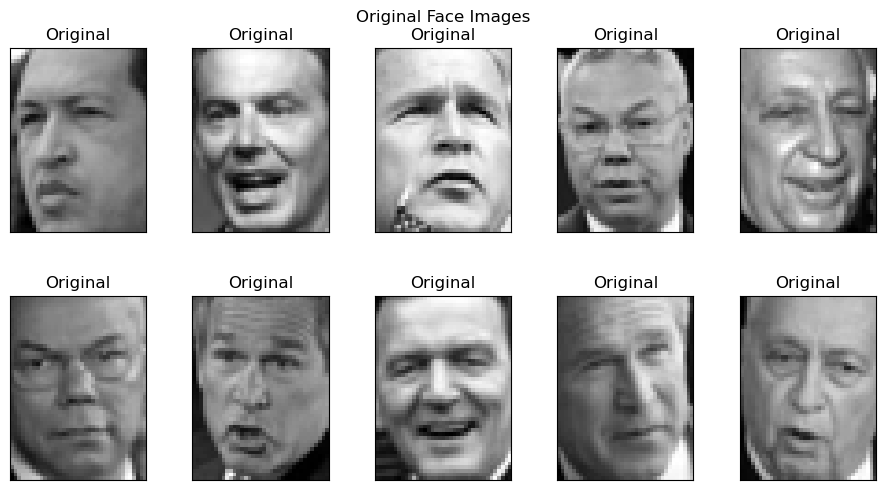

In [9]:
# LFWデータセットをロード
# 簡単化のため、最初の500枚の顔画像を使用
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
X = lfw_people.data[:500, :].T  # V (n x m) -> n:ピクセル数, m:サンプル数
n_samples, n_features = X.shape[1], X.shape[0]
h, w = lfw_people.images.shape[1], lfw_people.images.shape[2]

print(f"データ行列 V の形状: {X.shape}")
print(f"サンプル数 (m): {n_samples}, 特徴量数 (n): {n_features}")

def plot_faces(images, titles, h, w, n_row=2, n_col=5):
    """顔画像を表示するヘルパー関数"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

# 元の顔画像のサンプルを表示
plot_faces(X.T, ["Original"]*10, h, w)
plt.suptitle("Original Face Images")
plt.show()

## 3. 非負値行列因子分解 (Non-negative Matrix Factorization, NMF)

NMFは、LeeとSeungによって提案された行列因子分解の手法で、その名の通り、分解後の行列 $W$ と $H$ のすべての要素が**非負**であるという制約を持ちます。

$$
V \approx WH \quad \text{s.t.} \quad W_{ik} \ge 0, \quad H_{kj} \ge 0
$$

この非負制約が、NMFに「部分ベース」の表現を学習させる鍵となります。
元のデータ（例：顔画像）が非負のピクセル値で構成されている場合、そのデータを再構成するために基底ベクトルを組み合わせる際、引き算（負の係数）が許されません。これにより、NMFは全体的な特徴（PCAの固有顔のようなもの）ではなく、目、鼻、口といった直感的な「部分」を基底として学習する傾向があります。


### 3.1 NMFの更新則

NMFは、元の行列 $V$ と近似行列 $WH$ の間の距離（通常はフロベニウスノルムやKLダイバージェンス）を最小化する最適化問題として解かれます。LeeとSeungは、この問題を解くためのシンプルで効果的な**乗法的更新則**を提案しました。

**フロベニウスノルムを最小化する場合の更新則:**

$$
H \leftarrow H \odot \frac{W^T V}{W^T W H}
$$

$$
W \leftarrow W \odot \frac{V H^T}{W H H^T}
$$

ここで、
- $\odot$ は要素ごとの乗算（アダマール積）。
- 分数記号は要素ごとの除算。

この更新を繰り返すことで、$W$と$H$は距離関数を単調に減少させながら、局所最適解に収束します。

In [10]:
class NMF:
    def __init__(self, n_components=16, max_iter=200, tol=1e-4):
        self.n_components = n_components  # k: 基底の数
        self.max_iter = max_iter
        self.tol = tol
        self.components_ = None  # W: 基底行列
    
    def fit_transform(self, V):
        n_features, n_samples = V.shape
        k = self.n_components
        
        # WとHをランダムな非負値で初期化
        np.random.seed(42)
        W = np.random.rand(n_features, k)
        H = np.random.rand(k, n_samples)
        
        # 誤差を計算
        prev_error = np.linalg.norm(V - W @ H, 'fro')
        
        for i in range(self.max_iter):
            # Hの更新
            numerator_H = W.T @ V
            denominator_H = W.T @ W @ H + 1e-9  # ゼロ除算防止
            H *= numerator_H / denominator_H
            
            # Wの更新
            numerator_W = V @ H.T
            denominator_W = W @ H @ H.T + 1e-9  # ゼロ除算防止
            W *= numerator_W / denominator_W
            
            # 収束判定
            error = np.linalg.norm(V - W @ H, 'fro')
            if (prev_error - error) / prev_error < self.tol:
                print(f"Converged at iteration {i+1}")
                break
            prev_error = error

        self.components_ = W
        return H

Converged at iteration 309
NMF 基底行列 W の形状: (1850, 16)
NMF 係数行列 H の形状: (16, 500)


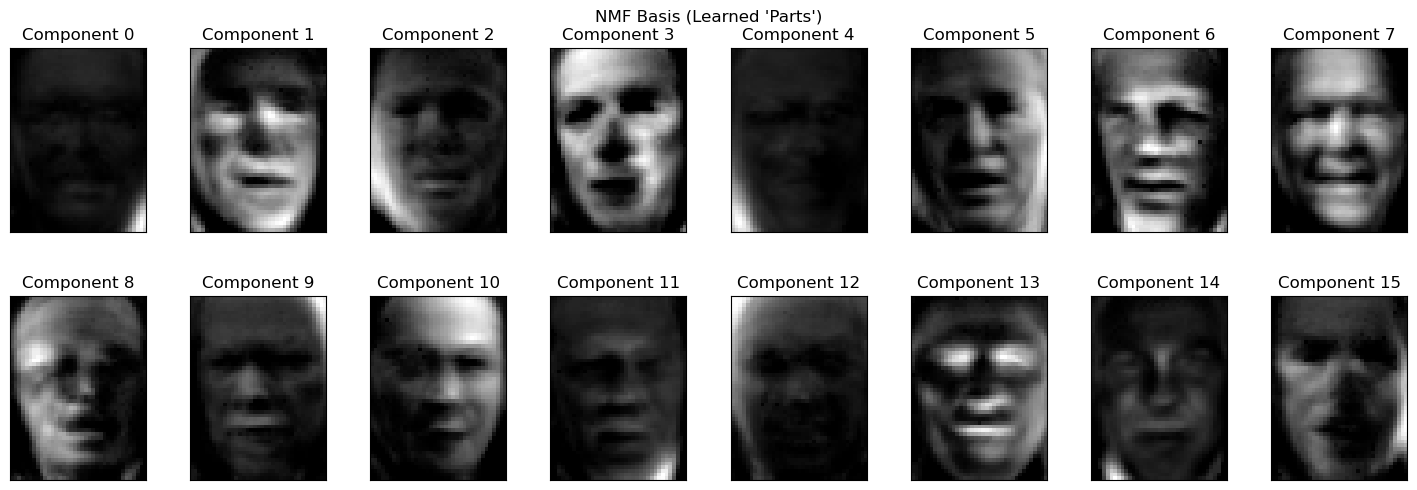

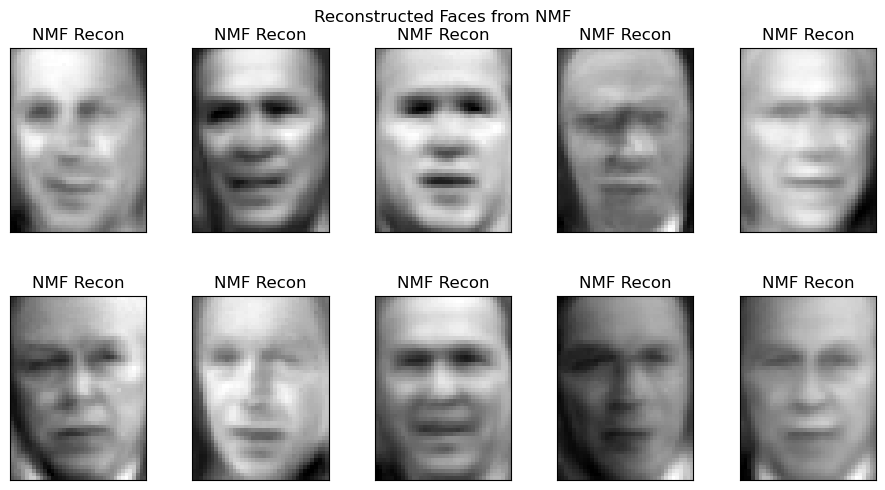

In [11]:
# NMFを実行して次元削減
n_components_nmf = 16
nmf = NMF(n_components=n_components_nmf, max_iter=500)
H_nmf = nmf.fit_transform(X)
W_nmf = nmf.components_

print("NMF 基底行列 W の形状:", W_nmf.shape)
print("NMF 係数行列 H の形状:", H_nmf.shape)

# 学習された基底（顔のパーツ）を表示
plot_faces(W_nmf.T, [f"Component {i}" for i in range(n_components_nmf)], h, w, n_row=2, n_col=8)
plt.suptitle("NMF Basis (Learned 'Parts')")
plt.show()

# いくつかの顔画像をNMFで再構成して表示
reconstructed_nmf = W_nmf @ H_nmf
plot_faces(reconstructed_nmf.T, ["NMF Recon"]*10, h, w)
plt.suptitle("Reconstructed Faces from NMF")
plt.show()

## 4. Uniform Manifold Approximation and Projection (UMAP)

UMAPは、t-SNEと並び、非線形次元削減と可視化のための最新かつ非常に強力な手法です。その理論的背景は位相的データ解析にありますが、計算的な観点からは以下の2つのステップで理解することができます。

1.  **高次元グラフの構築**: 高次元空間内のデータ点間の関係性を、重み付きの**k-近傍グラフ**として表現します。このステップでは、各点の局所的な距離のスケールを考慮して、点が「繋がっている」確率（重み）を計算します。
2.  **低次元レイアウトの最適化**: ステップ1で構築したグラフ構造を、低次元空間でも可能な限り保持するように、点の配置を最適化します。これは、グラフのエッジに沿って点を引き寄せる力（引力）と、全ての点が重ならないように反発させる力（斥力）をシミュレートする、一種の**力学モデル**として実装されます。

このアプローチにより、UMAPはt-SNEと同様に優れた局所構造の保持能力を持ちつつ、より大域的な構造も保持しやすいという特徴があります。

### 4.1 UMAPの計算的アルゴリズム（簡易版）

ここでは、UMAPの論文で示されている計算的な側面に焦点を当て、その中心的な処理を簡易的に実装します。

1.  **近傍グラフと重みの計算**: 各データ点についてk-近傍を見つけます。その後、各点からその近傍点への距離に基づいて、エッジの重み（類似度）を計算します。UMAPでは、各点の距離が局所的に一様な分布に従うと仮定し、この仮定に基づいて距離を正規化します。
2.  **グラフの対称化**: $i$から$j$への重みと$j$から$i$への重みは非対称な場合があるため、これらを組み合わせて対称な重みを持つグラフを構築します。
3.  **低次元埋め込みの初期化**: 通常はスペクトル埋め込みなどの手法で、低次元空間での点の初期配置を決定します。
4.  **勾配降下による最適化**: 高次元グラフの重み（類似度）と、低次元での点の配置から計算される重み（類似度）の差（交差エントロピー誤差）を最小化するように、勾配降下法で点の座標を繰り返し更新します。

In [12]:
class SimpleUMAP:
    def __init__(self, n_components=2, n_neighbors=15, min_dist=0.1, n_epochs=200, lr=1.0):
        self.n_components = n_components
        self.n_neighbors = n_neighbors
        self.min_dist = min_dist  # 低次元での最小距離
        self.n_epochs = n_epochs
        self.lr = lr
        self.graph_ = None
    
    def fit_transform(self, X):
        # Xの形状: (n_features, n_samples)
        n_samples = X.shape[1]  # 修正: サンプル数は列数

        # 1. 高次元グラフの構築
        knn = NearestNeighbors(n_neighbors=self.n_neighbors)
        knn.fit(X.T)  # X.T の形状: (n_samples, n_features)
        distances, indices = knn.kneighbors(X.T)
        
        # 自分自身への接続を除外（距離が0の場合）
        rows = []
        cols = []
        weights = []
        
        for i in range(n_samples):
            for j in range(self.n_neighbors):
                neighbor_idx = indices[i, j]
                distance = distances[i, j]
                # 自分自身への接続は除外
                if neighbor_idx != i and distance > 0:
                    rows.append(i)
                    cols.append(neighbor_idx)
                    weights.append(1.0 / (distance + 1e-6))
        
        rows = np.array(rows)
        cols = np.array(cols)
        weights = np.array(weights)
        
        # グラフ（隣接行列）
        self.graph_ = coo_matrix((weights, (rows, cols)), shape=(n_samples, n_samples))
        
        # グラフの対称化
        self.graph_ = self.graph_ + self.graph_.T - self.graph_.multiply(self.graph_.T)

        # 2. 低次元埋め込みの初期化
        np.random.seed(42)
        Y = np.random.randn(n_samples, self.n_components) * 0.0001
        
        # 3. 勾配降下による最適化
        # min_distに基づいて低次元での類似度曲線を設定
        # ここでは簡易的に引力と斥力の計算を行う
        edges = self.graph_.tocoo()
        for epoch in range(self.n_epochs):
            # 各エッジで引力を計算
            for i, j, w in zip(edges.row, edges.col, edges.data):
                if i >= j: continue
                dist_sq = np.sum(np.square(Y[i] - Y[j]))
                grad_mag = -2.0 * w / (dist_sq + 1.0) # 引力
                grad = grad_mag * (Y[i] - Y[j])
                Y[i] += self.lr * grad
                Y[j] -= self.lr * grad

            # 各点で斥力を計算 (ランダムサンプリングで近似)
            for i in range(n_samples):
                j = np.random.randint(n_samples)
                if i != j:  # 自分自身との斥力は計算しない
                    dist_sq = np.sum(np.square(Y[i] - Y[j]))
                    grad_mag = 2.0 / (dist_sq + 1.0) # 斥力
                    grad = grad_mag * (Y[i] - Y[j])
                    Y[i] += self.lr * grad
                
        return Y

In [13]:
# UMAPを実行 (簡易版)
# 注意: この実装は教育目的であり、最適化されていないため時間がかかります
# 実際の応用では公式ライブラリを使用してください
n_components_umap = 2
umap = SimpleUMAP(n_components=n_components_umap, n_neighbors=10, n_epochs=100, lr=0.1)
H_umap = umap.fit_transform(X) # UMAPの結果は直接低次元座標

print("UMAP 低次元埋め込みの形状:", H_umap.shape)

UMAP 低次元埋め込みの形状: (500, 2)


公式UMAPライブラリを使用した次元削減...


c:\Users\USER194\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


公式UMAP 低次元埋め込みの形状: (500, 2)


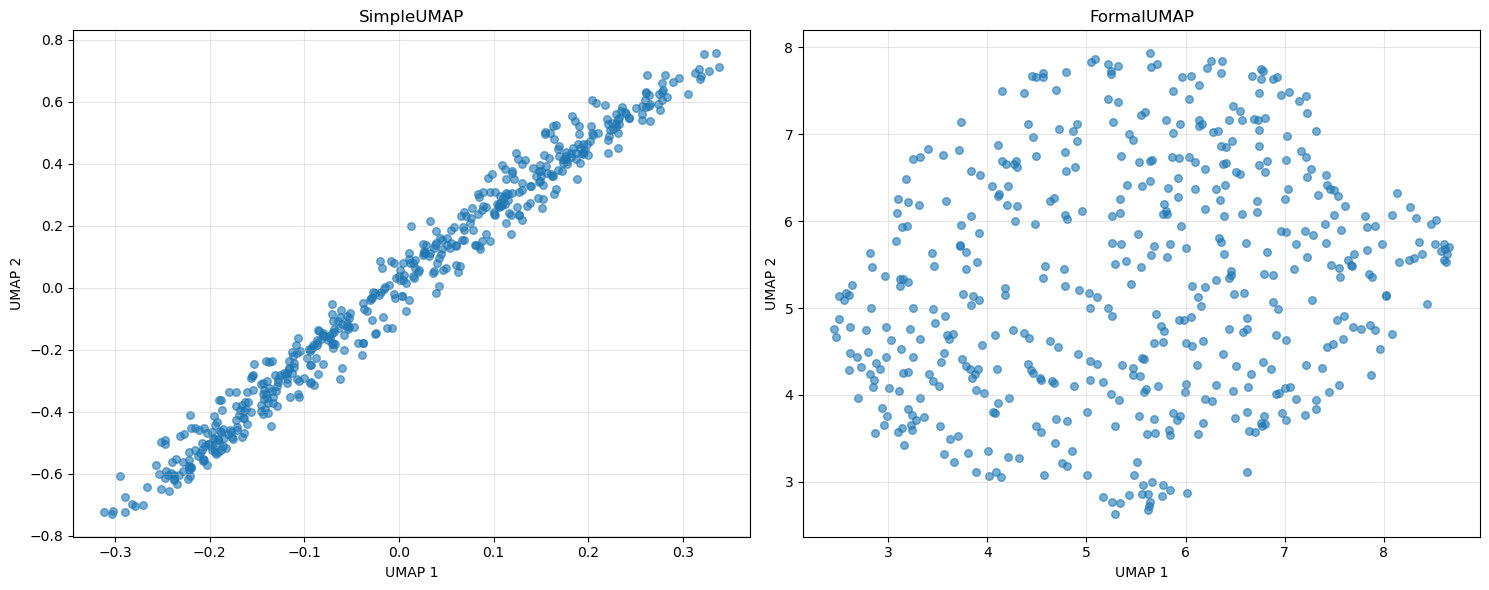

In [14]:
# UMAPの公式ライブラリを使った実験
from umap import UMAP
import seaborn as sns

# 公式UMAPライブラリを使用
print("公式UMAPライブラリを使用した次元削減...")
umap_official = UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
H_umap_official = umap_official.fit_transform(X.T)  # X.Tで(n_samples, n_features)に変換

print("公式UMAP 低次元埋め込みの形状:", H_umap_official.shape)

# 結果の可視化
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 簡易版UMAPの結果
axes[0].scatter(H_umap[:, 0], H_umap[:, 1], alpha=0.6, s=30)
axes[0].set_title("SimpleUMAP")
axes[0].set_xlabel("UMAP 1")
axes[0].set_ylabel("UMAP 2")
axes[0].grid(True, alpha=0.3)

# 公式UMAPの結果
axes[1].scatter(H_umap_official[:, 0], H_umap_official[:, 1], alpha=0.6, s=30)
axes[1].set_title("FormalUMAP")
axes[1].set_xlabel("UMAP 1")
axes[1].set_ylabel("UMAP 2")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. 結果の比較と考察

NMFとUMAP（ここではその簡易版）は、同じ次元削減という目的を、全く異なるアプローチで達成しようとします。

*   **NMFの基底**: NMFが学習した基底（特徴）は、顔の目、鼻、輪郭といった**直感的に理解しやすい「パーツ」**になっています。これは、非負制約によって、元の画像を足し算のみで再構成しようとする結果です。各顔画像は、これらのパーツをどれだけ使うかという係数（エンコーディング）で表現されます。NMFはデータの部分構造を抽出するのに優れており、**トピックモデリング**や**音源分離**など、混合信号を構成要素に分解するタスクで強力です。

*   **UMAPの埋め込み**: UMAPは、顔画像を2次元空間に配置します。この2次元空間の軸自体にNMFの基底のような直接的な意味はありません。その代わり、**点と点の間の距離**が重要になります。似た顔（例：同じ人物、似た表情や角度）は近くに配置され、異なる顔は遠くに配置される傾向があります。これにより、データ全体の**マニフォールド構造**（データがどのように分布し、関連しあっているか）を捉えることができます。UMAPは、クラスタリングや可視化、異常検知など、**データ全体の構造や関係性を理解する**タスクで特に有効です。

**結論:**
-   **NMF**は、データを構成する**「部分」や「成分」を理解したい**場合に適しています。分解された基底は解釈しやすいという利点があります。
-   **UMAP**は、データポイント間の**「類似性」や「大域的な構造」を低次元空間で保持したい**場合に適しています。特に可視化において強力な性能を発揮します。

これらの手法は互いに競合するものではなく、目的応じて使い分けるべき補完的なツールと言えるでしょう。